# PUBG Data Exploration + Random Forest (+ Funny GIFs)

[](http://)Hi fellow Kagglers! 

In this Kernel we ([Dalton Harmsen](https://www.kaggle.com/daltonharmsen), [Lourens Touwen](https://www.kaggle.com/lourenst) and [Carlo Lepelaars](https://www.kaggle.com/carlolepelaars)) will show you how we explore the [PUBG dataset](https://www.kaggle.com/c/pubg-finish-placement-prediction/data), detect outliers and recognize important features. We also implement a random forest model and optimize it.

If you like this Kaggle kernel, feel free to give an upvote and leave a comment.

A lot of inspiration for this kernel came from [fast.ai](https://www.fast.ai/)'s "[Machine Learning for Coders](https://course.fast.ai/ml)" course.

![alt text](https://o.aolcdn.com/images/dims?quality=100&image_uri=http%3A%2F%2Fo.aolcdn.com%2Fhss%2Fstorage%2Fmidas%2Fb0be09f425cc5175fb413bc03c32dd0d%2F206235889%2Fpubg-ed.jpg&client=amp-blogside-v2&signature=88c6b77342cbeb0d25c0dc9d909018136aec1971 "Logo Title Text 1")

# Table of Contents

* [Preparation](#1)
* [Extra Data (Coming Soon)](#2)
* [Initial Exploration](#3)
* [Illegal Match](#4)
* [Feature Engineering](#5)
* [Outlier Detection](#6)
* [Categorical Variables](#7)
* [Preparation for Machine Learning](#8)
* [Feature Importance](#9)
* [Final Random Forest Model](#10)
* [Kaggle Submission](#11)


# Let's Go!

![Alt Text](https://media.giphy.com/media/xT9IgnOQS8e8uKkflK/giphy.gif)
giphy2

# Preparation <a id="1"></a>

First we import the dependencies needed for handling data, visualization and training our model. 

Important dependencies are:
* [Pandas](https://pandas.pydata.org) for their dataframe structures and easy visualization.
* [Matplotlib](https://matplotlib.org) for visualization.
* [Scikit-learn](https://scikit-learn.org/stable) for machine learning.
* [fastai](https://www.fast.ai) for machine learning and feature importance.

In [ ]:
## Something went wrong when importing fastai.structured.
## We fixed this by put the whole source code of fastai.structured in the notebook.
## This was copied from: https://github.com/anandsaha/fastai.part1.v2/blob/master/fastai/structured.py

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    2     3    a
    1     2    b
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def proc_df(df, y_fld, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):

    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    do_scale: Standardizes each column in df,Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time(mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [2]:
# For autoreloading modules
%load_ext autoreload
%autoreload 2
# For notebook plotting
%matplotlib inline

# Standard libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# from pdpbox import pdp
# from plotnine import *
# from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

# Machine Learning
import sklearn
from sklearn import metrics
from scipy.cluster import hierarchy as hc
# from fastai.imports import *
import scipy

# Directories
KAGGLE_DIR = '../input/'

# Info about dataset
print('Files and directories: \n{}\n'.format(os.listdir("../input")))

print('\n# File sizes')
for file in os.listdir(KAGGLE_DIR):
    # ljust 如果少于指定的数量，则使用指定的字符进行填充，默认为空，如果小于则不理会
    print('{}| {} MB'.format(file.ljust (30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2)))) # round 四舍五入，指定后两位

D:\python\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\python\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\python\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


Files and directories: 
['sample_submission_V2.csv', 'test_V2.csv', 'train_V2.csv']


# File sizes
sample_submission_V2.csv      | 32.88 MB
test_V2.csv                   | 273.24 MB
train_V2.csv                  | 659.54 MB


In [3]:
str1 = "this is string example....wow!!!";

str1.ljust(10, '0')

'this is string example....wow!!!'

And of course, we import our data from the Kaggle kernel directory and load it into two different DataFrames. one for the training data and one for the test data.

In [4]:
# Import dataset
train = pd.read_csv(KAGGLE_DIR + 'train_V2.csv')
test = pd.read_csv(KAGGLE_DIR + 'test_V2.csv')

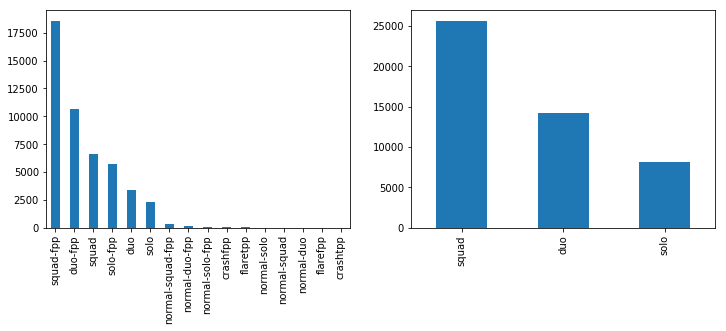

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

mapper = lambda x: 'solo' if ('solo' in x)  else 'duo' if ('duo' in x) or ('crash' in x) else 'squad' 
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

In [28]:
import itertools
def toTapleList(list1,list2):
    return list(itertools.product(list1,list2))

In [65]:
cols = ['numGroups','maxPlace']
desc1 = train.groupby('matchType')[cols].describe()[toTapleList(cols,['min','mean','max'])]
group = train.groupby(['matchType','matchId','groupId']).count().groupby(['matchType','matchId']).size().to_frame('groups in match')
desc2 = group.groupby(['matchType']).describe()[toTapleList(['groups in match'],['min','mean','max'])]
pd.concat([desc1,desc2],axis=1)

numGroups                   maxPlace                    \
                min       mean    max      min       mean    max   
matchType                                                          
duo             1.0  45.812482   52.0      3.0  47.608919   52.0   
solo            1.0  91.115157  100.0      1.0  93.908771  100.0   
squad           2.0  27.039389   37.0      2.0  27.982982   37.0   

          groups in match                    
                      min       mean    max  
matchType                                    
duo                   1.0  45.348777   52.0  
solo                  1.0  85.669426  100.0  
squad                 2.0  26.834984   37.0

![API Img](http://media.comicbook.com/2018/03/pubg-api-1093349.jpeg)


# Initial Exploration <a id="3"></a>

In [21]:
if group1 == group:
    print('yes')

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Let's look at the DataFrame from head to tail.

In [4]:
# First five rows (From Head)
print('First 5 rows: ')
display(train.head())

# Last five rows (To Tail)
print('Last 5 rows: ')
display(train.tail())

First 5 rows: 


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


Last 5 rows: 


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0,0,0.000,0,0,1019.0,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0,0,0.000,0,0,81.7,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0,0,2.184,0,0,788.7,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0,0,0.000,0,0,2748.0,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00,0,0,1,18,...,0,1369.0,0,0.000,0,0,1244.0,5,0,0.5464


Summary Statistics of the training data.

In [5]:
# Stats
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [6]:
train.describe(include=['O'])

,Id,groupId,matchId,matchType
count,4446966,4446966,4446966,4446966
unique,4446966,2026745,47965,16
top,3b3e7a704cc7fb,14d6b54cdec6bc,2f70b426deca6b,squad-fpp
freq,1,74,100,1756186


Data types, memory usage, shape, etc.

In [7]:
# Types, Data points, memory usage, etc.
train.info()

# Check dataframe's shape
print('Shape of training set: ', train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB
Shape of training set:  (4446966, 29)


#### 查看缺失数据

In [8]:
miss = train.isna().sum().sort_values(ascending=False)
total = train.count()
percent = (miss/total*100).sort_values(ascending=False)
miss_data=pd.concat([miss,percent],axis=1,keys=['Total','Percent'],sort=False)
miss_data.head()

,Total,Percent
winPlacePerc,1,0.000022
longestKill,0,0.000000
groupId,0,0.000000
matchId,0,0.000000
assists,0,0.000000


### Feature descriptions (From Kaggle)

* DBNOs - Number of enemy players knocked.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* Id - Player’s Id
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks - Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify match. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

[Source](https://www.kaggle.com/c/pubg-finish-placement-prediction/data)

In [9]:
# Use this code if you want to store and read DataFrames in a feather format
# os.makedirs('tmp', exist_ok=True)
# train.to_feather('tmp/PUBG')
# df_raw = pd.read_feather('tmp/PUBG')

# Illegal Match <a id="4"></a>

Fellow Kaggler '[averagemn](https://www.kaggle.com/donkeys)' brought to our attention that there is one particular player with a 'winPlacePerc' of NaN. The case was that this match had only one player. We will delete this row from our dataset.

In [10]:
# Check row with NaN value
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


Let's delete this entry:

In [11]:
# Drop row with NaN 'winPlacePerc' value
train.drop(2744604, inplace=True)

And he's gone!

In [12]:
# The row at index 2744604 will be gone
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


# EDA <a id="5"></a>

### The Killers

In [24]:
'The average person kills {:.4f} players,99% of people hava {} kills or less ,while the most kills ever recorded is {}'.format(train['kills'].mean(),train['kills'].quantile(0.99),train['kills'].max())

'The average person kills 0.9248 players,99% of people hava 7.0 kills or less ,while the most kills ever recorded is 72'

In [29]:
train['kills'].quantile(0.90)

3.0

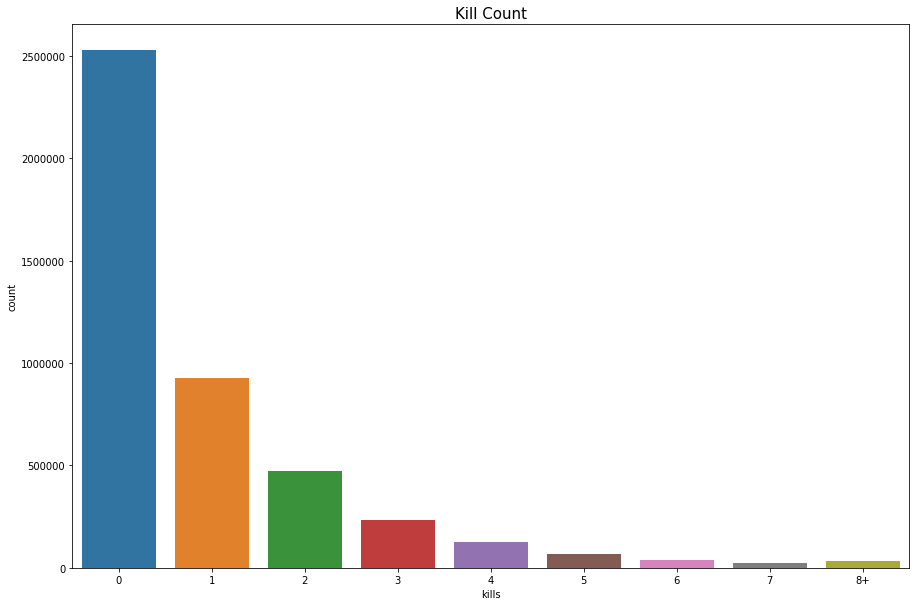

In [34]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

从图中我们可以看出，大部分的人没有杀死一个人

#### 查看击杀为0的人所造成的的总伤害 damageDealt

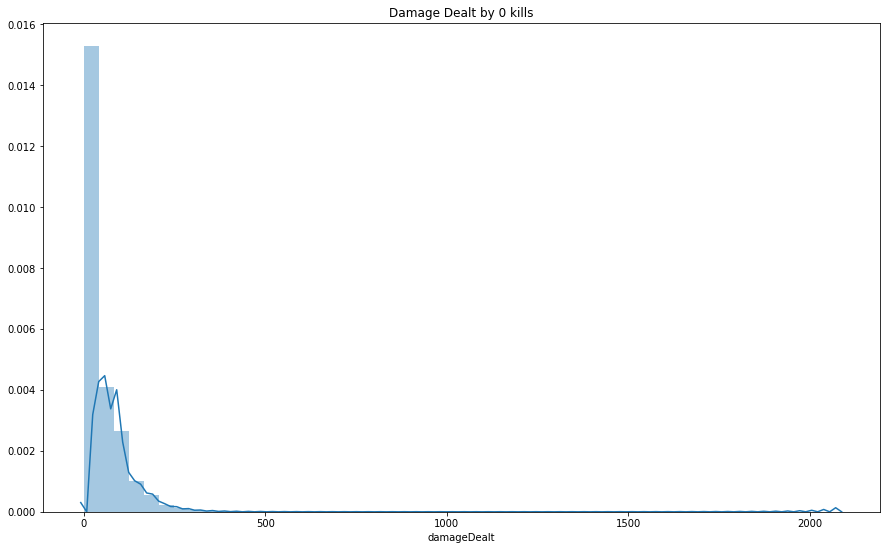

In [36]:
data=train.copy()
data=data[data['kills']==0]
plt.figure(figsize=(15,9))
sns.distplot(data['damageDealt'])
plt.title('Damage Dealt by 0 kills')
plt.show()

从图中我们可以看出 kills=0的人 大部分都没有给对方造成伤害

In [44]:
'{} 个人 ({:.4f}%) 没有杀死一个人但是却赢得了比赛'.format(len(data[data['winPlacePerc']==1]),len(data[data['winPlacePerc']==1])/len(train)*100)

'16666 个人 (0.3748%) 没有杀死一个人但是却赢得了比赛'

In [55]:
' {} 个人 ({:.4f}%) 没有造成任何伤害但是却赢得了比赛'.format(len(data[(data['winPlacePerc']==1)&(data['damageDealt']==0)]),len(data[(data['winPlacePerc']==1)&(data['damageDealt']==0)])/len(train)*100)

' 4709 个人 0.1059 没有造成任何伤害但是却赢得了比赛'

#### 查看一下 winPlacePerc 和  kills 之间的关系图

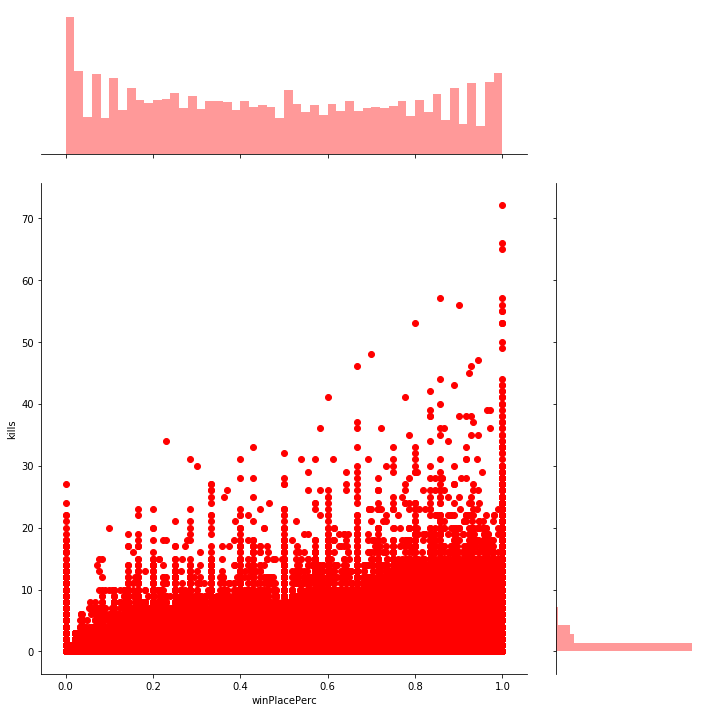

In [56]:
sns.jointplot(x='winPlacePerc',y='kills',data=train,height=10,ratio=3,color='r')
plt.show()

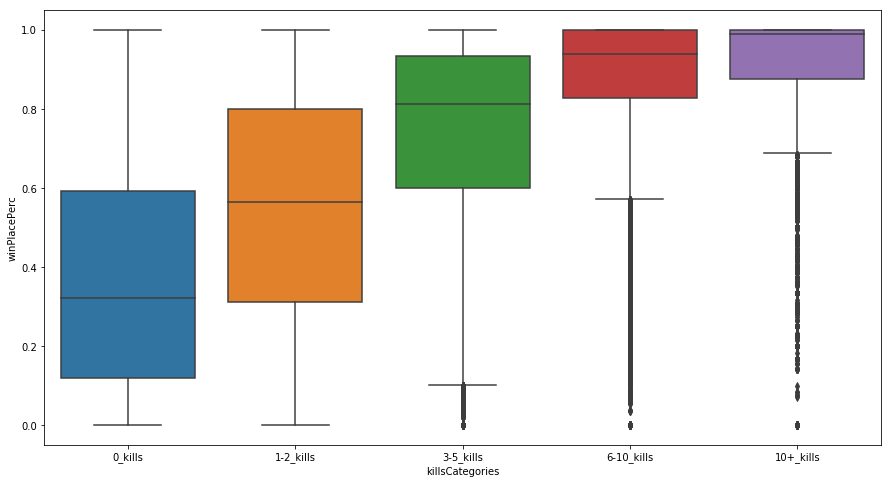

In [57]:
kills = train.copy()
kills['killsCategories'] = pd.cut(kills['kills'],[-1,0,2,5,10,60],labels=['0_kills','1-2_kills','3-5_kills','6-10_kills','10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x='killsCategories',y='winPlacePerc',data=kills)
plt.show()

### The Runners

In [11]:
'The average person walks for {:.1f}m, 99% of person have walked {}m or less , while the marathoner champion walked for {}m.'.format(train['walkDistance'].mean(),train['walkDistance'].quantile(0.99),train['walkDistance'].max())

'The average person walks for 1154.2m, 99% of person have walked 4396.0m or less , while the marathoner champion walked for 25780.0m.'

#### 查看 walkDistance  的分布

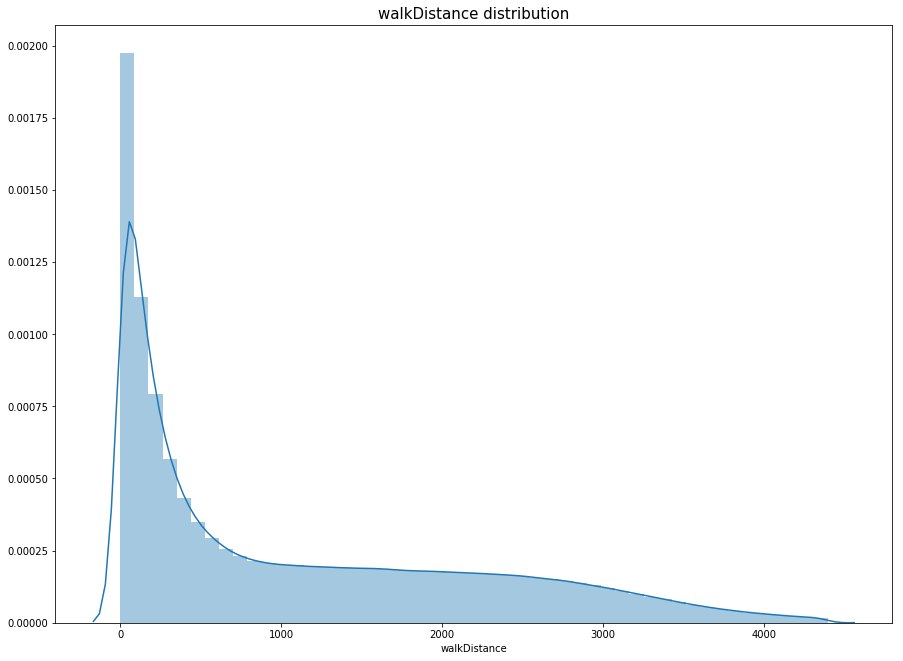

In [13]:
data = train.copy()
data = data[data['walkDistance']<data['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,11))
plt.title('walkDistance distribution',fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

#### 查看 walkDistance=0  的人，相当于挂机

In [15]:
"{} players ({:.4f}%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible)".format(len(data[data['walkDistance']==0]),len(data[data['walkDistance']==0])/len(train))

'99603 players (0.0224%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible)'

#### 查看 walkDistance  和 winPlacePerc  的关系

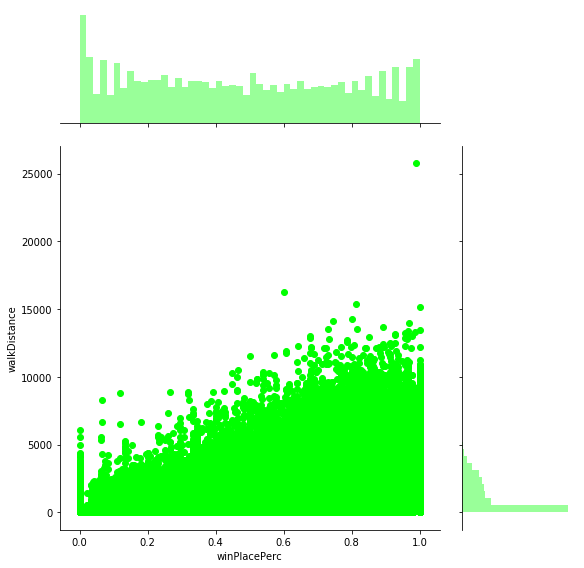

In [18]:
sns.jointplot(x='winPlacePerc',y='walkDistance',data=train,height=8,ratio=3,color='lime')
plt.show()

### The Drivers

In [19]:
print("The average person drives for {:.1f}m, 99% of people have drived {}m or less, while the formula 1 champion drived for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

The average person drives for 606.1m, 99% of people have drived 6966.0m or less, while the formula 1 champion drived for 40710.0m.


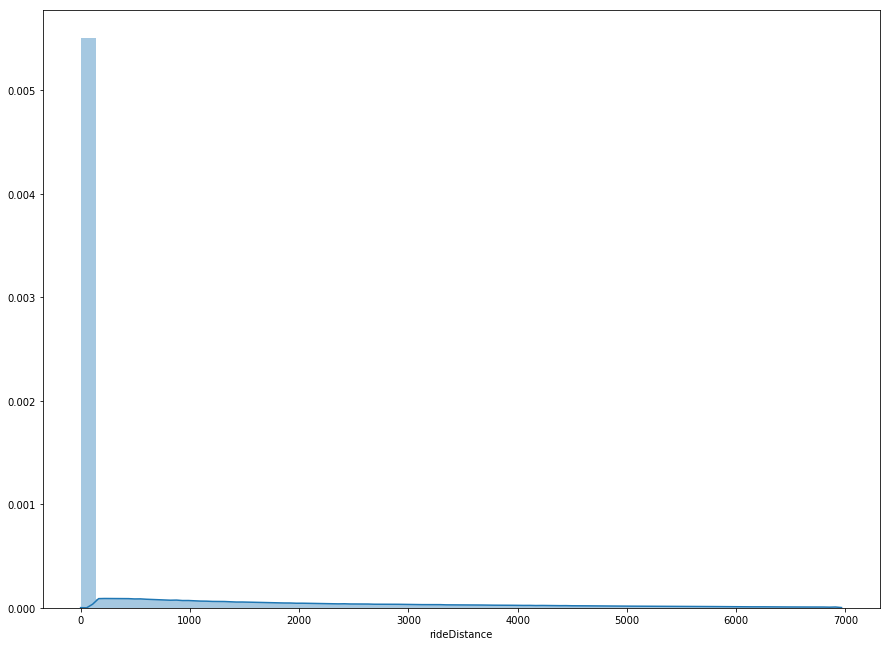

In [20]:
data = train.copy()
data = data[data['rideDistance'] < data['rideDistance'].quantile(0.99)]
plt.figure(figsize=(15,11))
sns.distplot(data['rideDistance'])
plt.show()

In [22]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they don't have a driving licence yet.".format(len(data[data['rideDistance'] == 0]), 100*len(data[data['rideDistance']==0])/len(train)))

3309429 players (74.4199%) drived for 0 meters. This means that they don't have a driving licence yet.


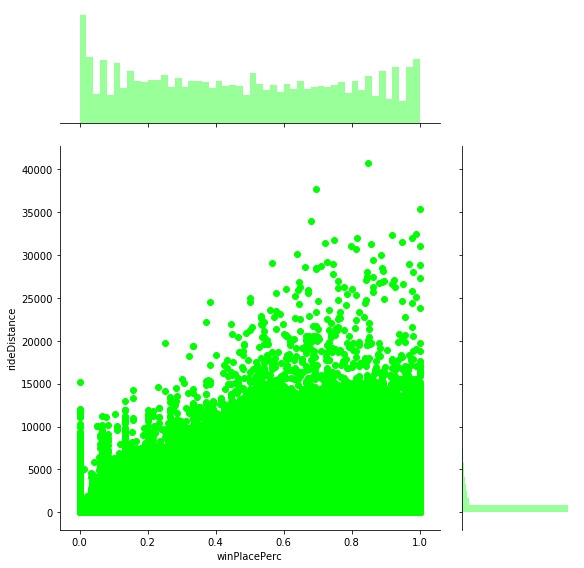

In [23]:
sns.jointplot(x='winPlacePerc',y='rideDistance',data=train,height=8,ratio=3,color='lime')
plt.show()

#### 根据我的经验摧毁车辆表明玩家有技能。 我们来检查吧。

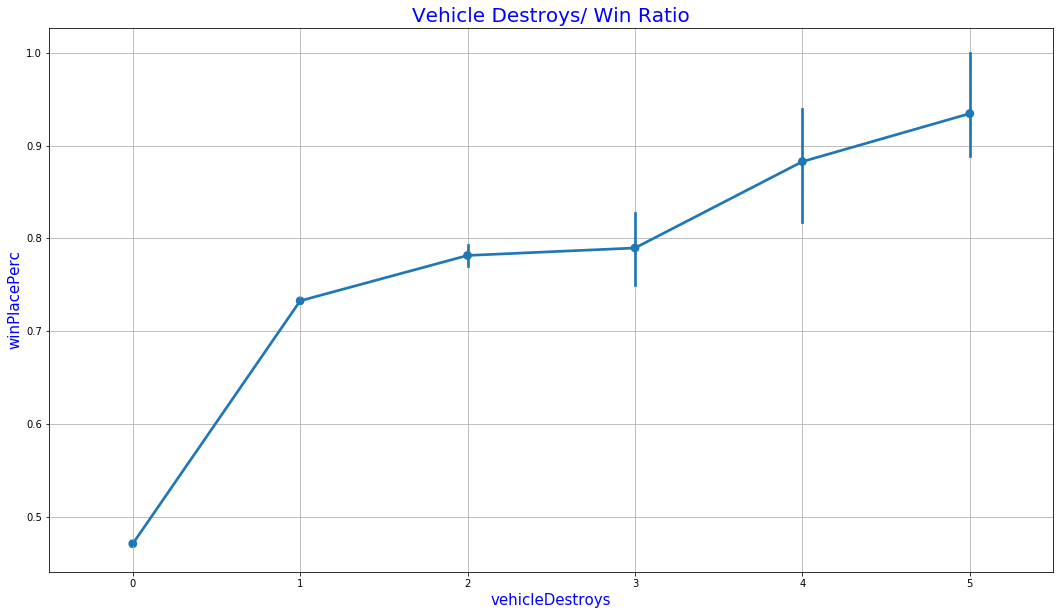

In [16]:
plt.figure(figsize=(18,10))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=train,height=10,ratio=3,alpha=0.8)
plt.xlabel('vehicleDestroys',fontsize=15,color='blue')
plt.ylabel('winPlacePerc',fontsize=15,color='blue')
plt.title('Vehicle Destroys/ Win Ratio',fontsize = 20,color='blue')
# 背景使用网格图
plt.grid()
plt.show()

### The Swimmers

In [15]:
print("The average person swims for {:.1f}m, 99% of people have swimemd {}m or less, while the olympic champion swimmed for {}m.".format(train['swimDistance'].mean(), train['swimDistance'].quantile(0.99), train['swimDistance'].max()))

The average person swims for 4.5m, 99% of people have swimemd 123.0m or less, while the olympic champion swimmed for 3823.0m.


In [26]:
train['swimDistance'].quantile(0.94)

3.513

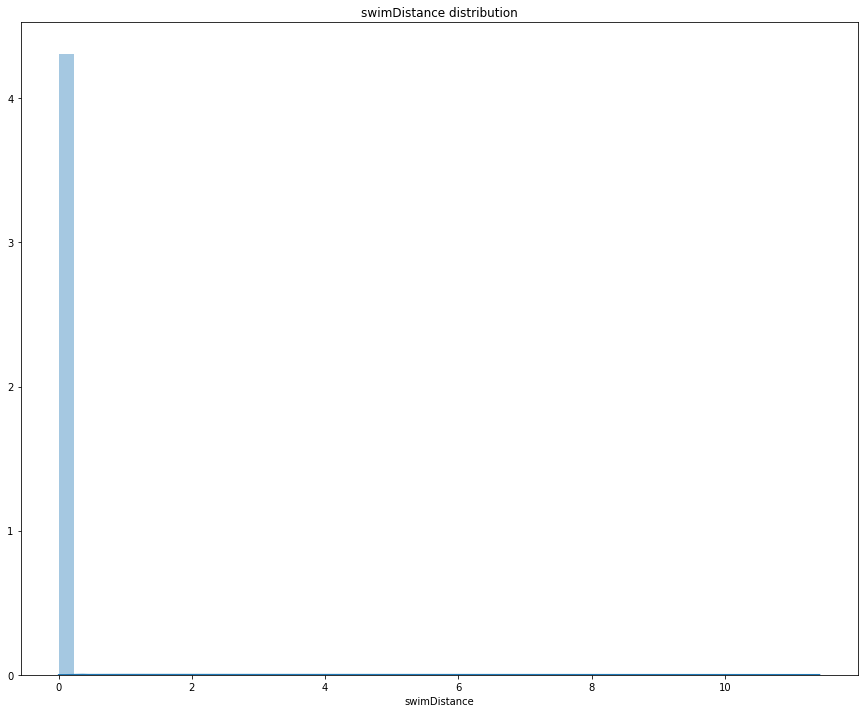

In [19]:
data = train.copy()
data = data[data['swimDistance'] < data['swimDistance'].quantile(0.95)]
plt.figure(figsize=(15,12))
plt.title('swimDistance distribution')
sns.distplot(data['swimDistance'])

plt.show()

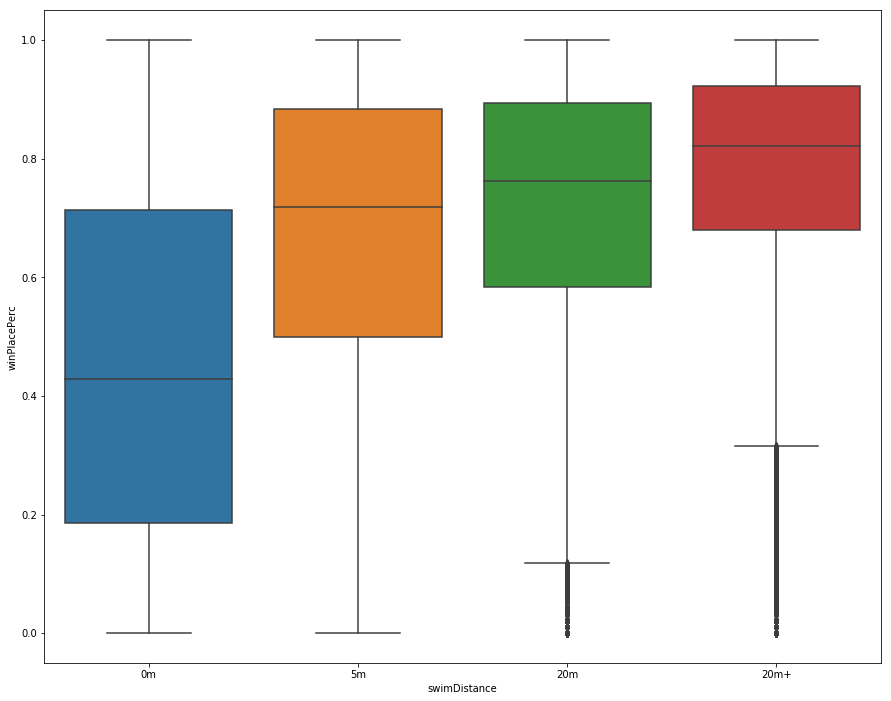

In [28]:
swim  = train.copy()
swim['swimDistance'] = pd.cut(swim['swimDistance'],[-1,0,5,20,3823],labels=['0m','5m','20m','20m+'])

plt.figure(figsize=(15,12))
sns.boxplot(x='swimDistance',y='winPlacePerc',data=swim)
plt.show()

### The Healers

In [29]:
print("The average person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("The average person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

The average person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
The average person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


#### 绘制图像对比 heal 和 boost 对于winPlacePerc的影响

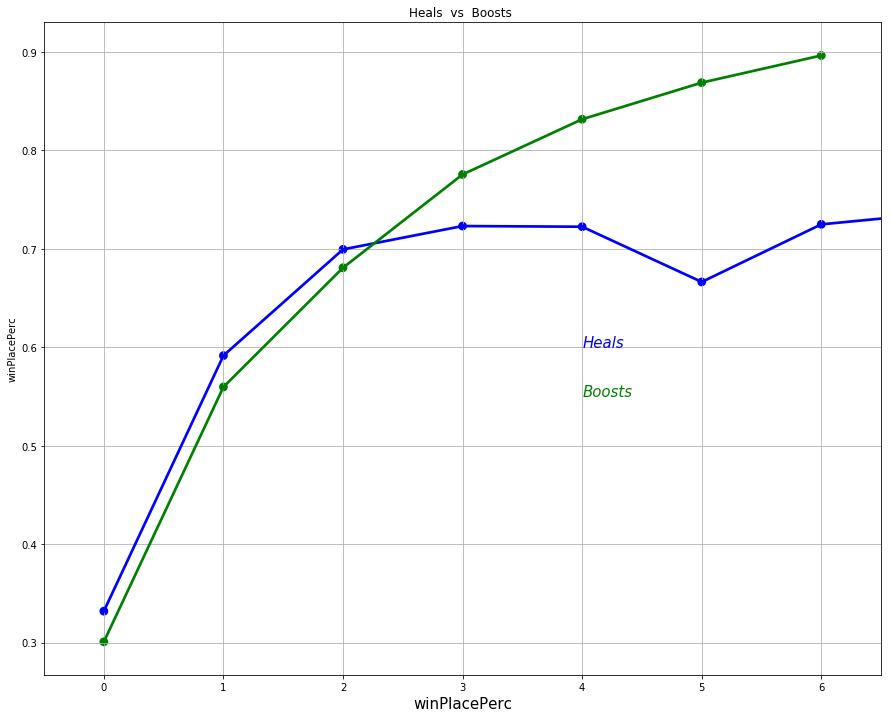

In [31]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

plt.figure(figsize=(15,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,height=10,ratio=3,color='blue')
sns.pointplot(x='boosts',y='winPlacePerc',data=data,height=10,ratio=3,color='green')
plt.text(4,0.6,'Heals',color='blue',fontsize=15,style='italic')
plt.text(4,0.55,'Boosts',color='green',fontsize=15,style='italic')
plt.xlabel('Heals/Boosts',fontsize=15)
plt.xlabel('winPlacePerc',fontsize=15)
plt.title('Heals  vs  Boosts ')
plt.grid()
plt.show()

# heals and boost effect

#### 看看heal对winplaceperc的影响

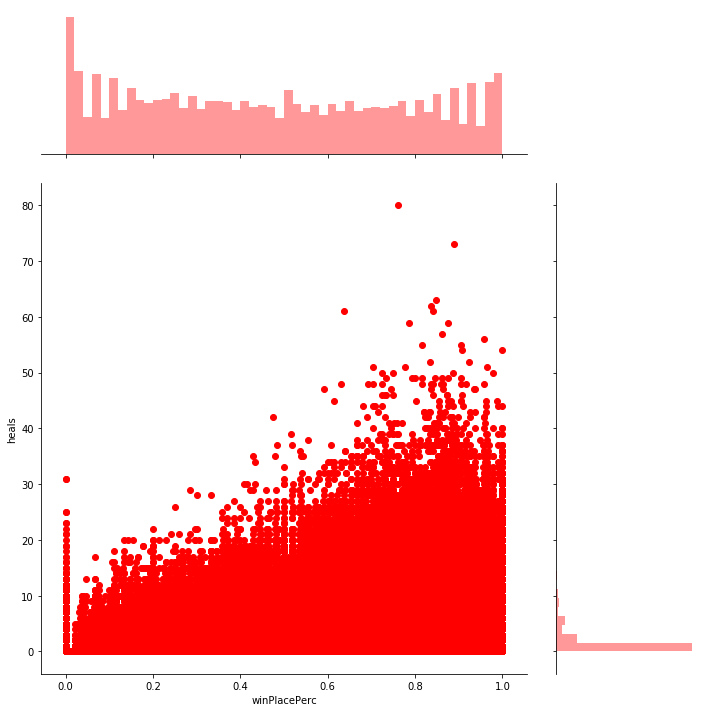

In [33]:
sns.jointplot(x='winPlacePerc',y='heals',data=train,height=10,ratio=3,color='r')
plt.show()

#### 看看heal对winplaceperc的影响

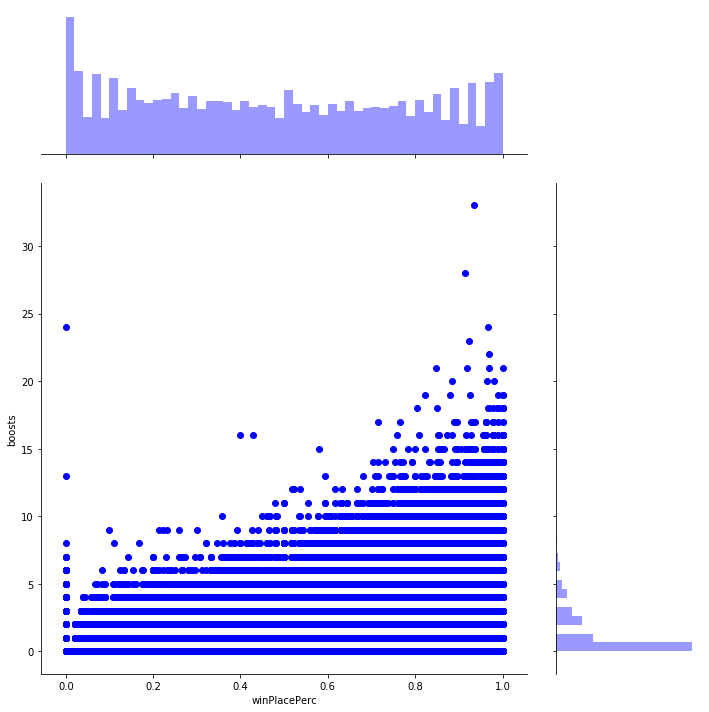

In [34]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="blue")
plt.show()

### Solos, Duos and Squads

#### 游戏中有分队，其中有一个人玩的，有2个人组队玩的，也有四个人一起组队玩的，现在来查看一下他们之间的胜率

In [35]:
solo = train[train['numGroups'] > 50]
duos = train[(train['numGroups'] > 25) & (train['numGroups'] <= 50)]
squads = train[train['numGroups'] <= 25]

print('在数据中 玩 solo 的有 {}个人({:.2f}%)，玩 duos 的有 {}个人({:.2f}%)，玩 squads 的有 {}个人({:.2f}%)'.format(len(solo),
                                                                                             len(solo)/len(train),
                                                                                             len(duos),
                                                                                             len(duos)/len(train),
                                                                                             len(squads),
                                                                                             len(squads)/len(train)))

在数据中 玩 solo 的有 709111个人(0.16%)，玩 duos 的有 3295326个人(0.74%)，玩 squads 的有 442528个人(0.10%)


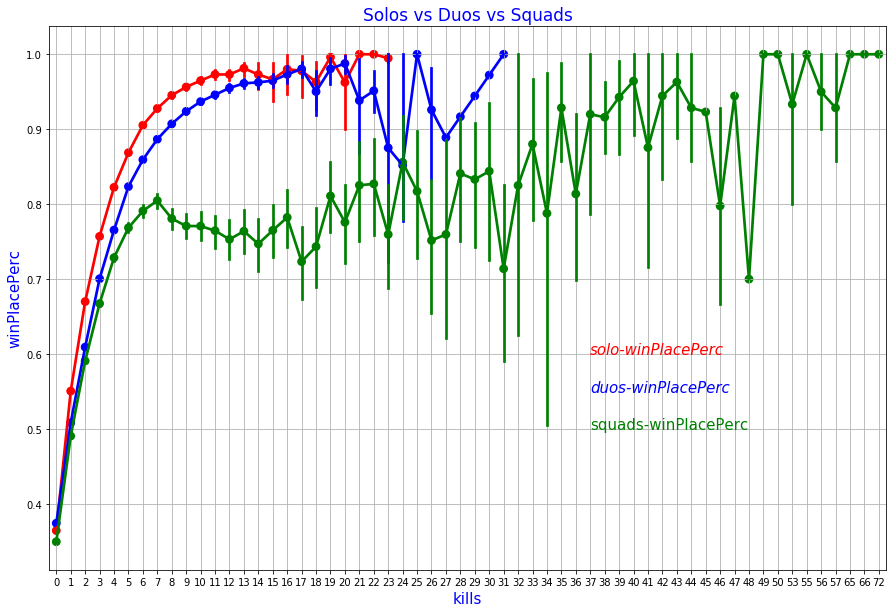

In [38]:
plt.figure(figsize=(15,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solo,height=10,ratio=3,color='r')
sns.pointplot(x='kills',y='winPlacePerc',data=duos,height=10,ratio=3,color='blue')
sns.pointplot(x='kills',y='winPlacePerc',data=squads,height=10,ratio=3,color='green')

plt.text(37,0.6,'solo-winPlacePerc',fontsize=15,color='r',style='italic')
plt.text(37,0.55,'duos-winPlacePerc',fontsize=15,color='blue',style='italic')
plt.text(37,0.50,'squads-winPlacePerc',fontsize=15,color='green')

plt.xlabel('kills',fontsize=15,color='blue')
plt.ylabel('winPlacePerc',fontsize=15,color='blue')

plt.title('Solos vs Duos vs Squads',fontsize=17,color='blue')
plt.grid()
plt.show()

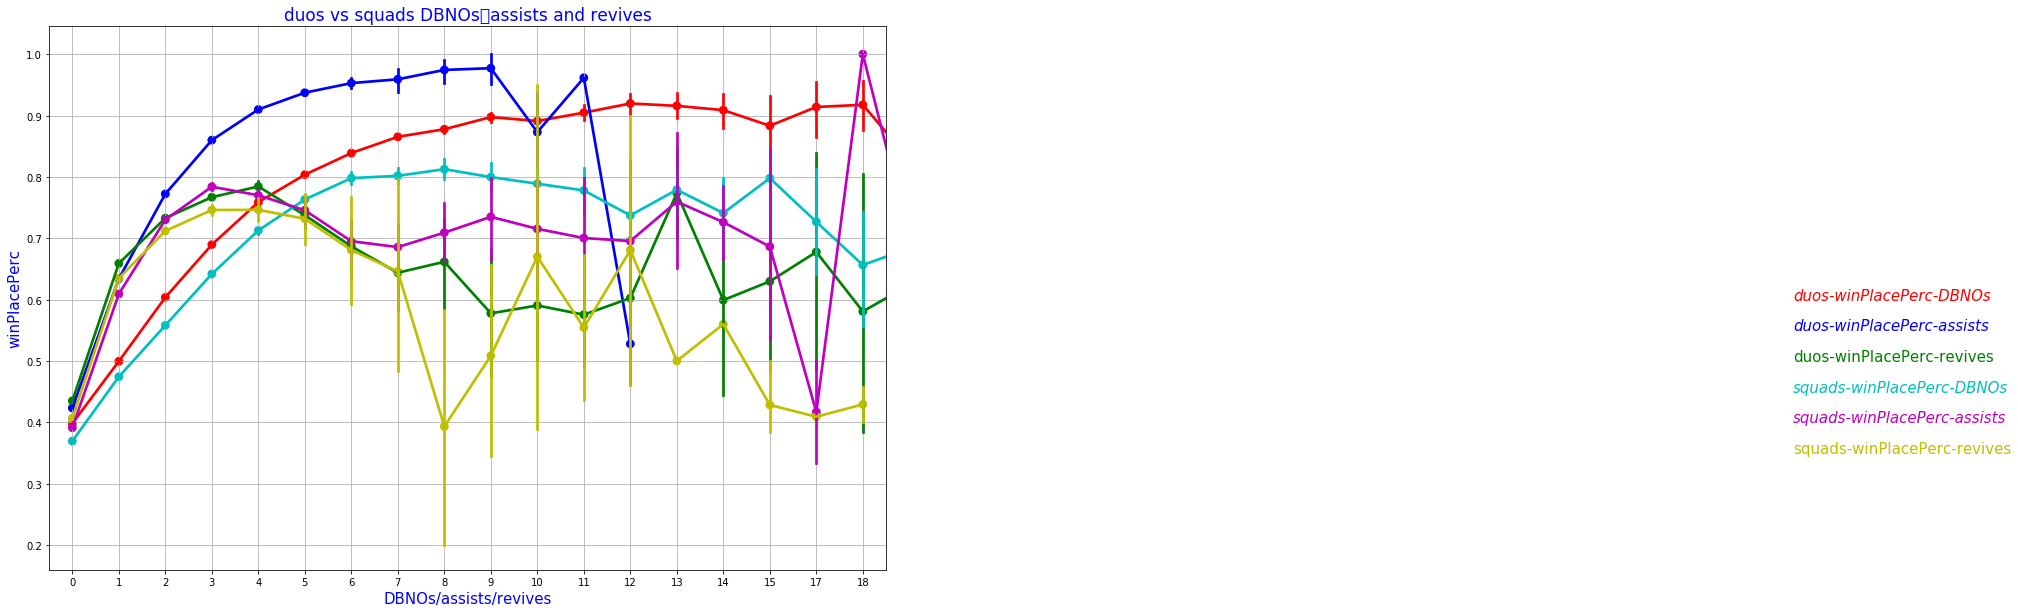

In [40]:
plt.figure(figsize=(15,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duos,height=10,ratio=3,color='r')
sns.pointplot(x='assists',y='winPlacePerc',data=duos,height=10,ratio=3,color='blue')
sns.pointplot(x='revives',y='winPlacePerc',data=duos,height=10,ratio=3,color='green')

sns.pointplot(x='DBNOs',y='winPlacePerc',data=squads,height=10,ratio=3,color='c')
sns.pointplot(x='assists',y='winPlacePerc',data=squads,height=10,ratio=3,color='m')
sns.pointplot(x='revives',y='winPlacePerc',data=squads,height=10,ratio=3,color='y')

plt.text(14,0.6,'duos-winPlacePerc-DBNOs',fontsize=15,color='r',style='italic')
plt.text(14,0.55,'duos-winPlacePerc-assists',fontsize=15,color='blue',style='italic')
plt.text(14,0.50,'duos-winPlacePerc-revives',fontsize=15,color='green')
plt.text(14,0.45,'squads-winPlacePerc-DBNOs',fontsize=15,color='c',style='italic')
plt.text(14,0.40,'squads-winPlacePerc-assists',fontsize=15,color='m',style='italic')
plt.text(14,0.35,'squads-winPlacePerc-revives',fontsize=15,color='y')

plt.xlabel('DBNOs/assists/revives',fontsize=15,color='blue')
plt.ylabel('winPlacePerc',fontsize=15,color='blue')

plt.title('duos vs squads DBNOs、assists and revives',fontsize=17,color='blue')
plt.grid()
plt.show()

#### 热力图查看前五条 和 胜利关联性较大的特征

In [42]:
train.corr()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
assists,1.000000,0.307683,0.406726,0.301057,0.198289,0.228556,-0.290062,0.039066,0.319690,0.243471,...,0.198320,0.110644,0.011903,0.023372,0.006081,0.057921,0.290305,0.243882,0.024014,0.299441
boosts,0.307683,1.000000,0.521947,0.358907,0.334661,0.535854,-0.554844,0.008347,0.502024,0.405327,...,0.253125,0.328855,0.035124,0.107993,0.013068,0.087387,0.640150,0.406609,-0.007645,0.634234
damageDealt,0.406726,0.521947,1.000000,0.735763,0.613409,0.342987,-0.677398,0.049904,0.888783,0.703599,...,0.256951,0.140883,0.052487,0.036729,0.015468,0.081182,0.398199,0.353248,0.017762,0.440507
DBNOs,0.301057,0.358907,0.735763,1.000000,0.469923,0.265485,-0.555290,0.042616,0.707848,0.646872,...,0.300999,0.102537,0.036093,0.017320,0.069430,0.060210,0.284660,0.218161,0.011108,0.279970
headshotKills,0.198289,0.334661,0.613409,0.469923,1.000000,0.199917,-0.469829,0.023988,0.674275,0.512882,...,0.150145,0.076495,0.013369,0.028531,0.008658,0.039200,0.250982,0.217552,0.004982,0.277722
heals,0.228556,0.535854,0.342987,0.265485,0.199917,1.000000,-0.386032,-0.002585,0.311781,0.270412,...,0.236680,0.297484,0.024619,0.079587,0.035386,0.062870,0.430266,0.309071,-0.010990,0.427857
killPlace,-0.290062,-0.554844,-0.677398,-0.555290,-0.469829,-0.386032,1.000000,-0.023278,-0.730499,-0.810517,...,-0.269804,-0.236202,-0.057356,-0.089396,-0.037797,-0.073569,-0.590236,-0.490144,-0.002415,-0.719069
killPoints,0.039066,0.008347,0.049904,0.042616,0.023988,-0.002585,-0.023278,1.000000,0.036192,0.037091,...,0.012041,-0.029316,-0.004156,-0.004604,-0.039739,-0.009658,0.004630,-0.003978,0.983417,0.012908
kills,0.319690,0.502024,0.888783,0.707848,0.674275,0.311781,-0.730499,0.036192,1.000000,0.802500,...,0.253323,0.114750,0.063651,0.039127,0.017601,0.079991,0.374774,0.336414,0.006929,0.419916
killStreaks,0.243471,0.405327,0.703599,0.646872,0.512882,0.270412,-0.810517,0.037091,0.802500,1.000000,...,0.241695,0.098420,0.065575,0.034588,0.027612,0.064374,0.327639,0.275373,0.008552,0.377566


# heatmap picture

In [11]:
train.corr().shape

(25, 25)

In [4]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [9]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(20, 20))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

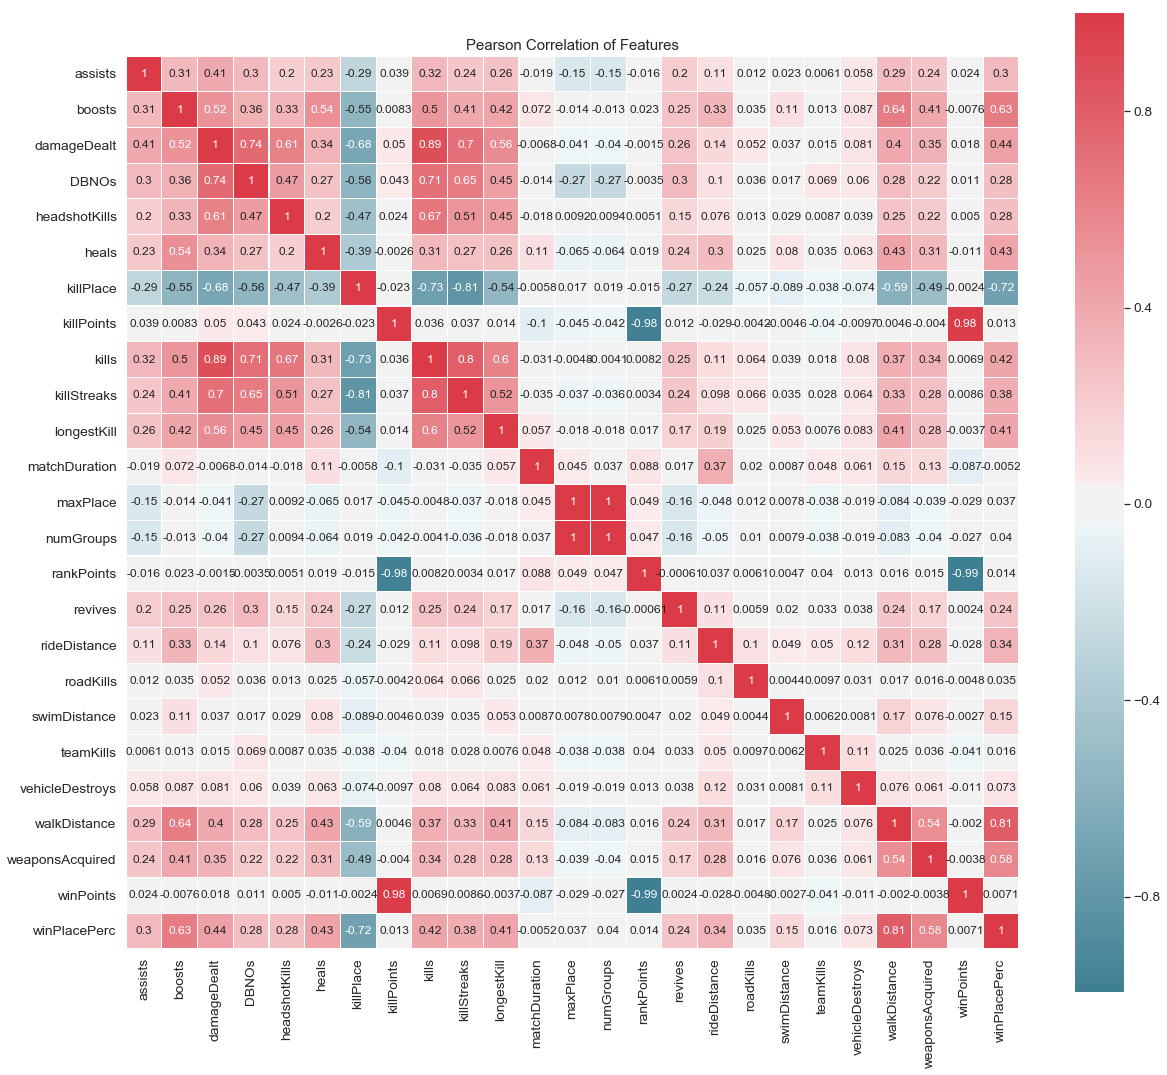

In [10]:
correlation_heatmap(train)

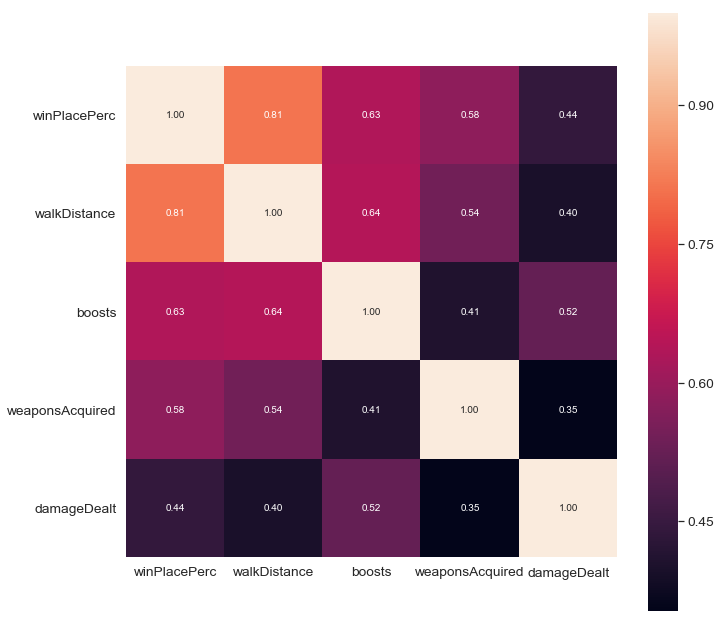

In [18]:
k=5
f,ax = plt.subplots(figsize=(11, 11))
# 取 winPlacePerc 列中值最大的(有正负之分，负相关强的不予显示)
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
# 计算协方差矩阵
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Feature Engineering <a id="5"></a>

Earlier in this kernel we created the new features ''totalDistance'' and  ''headshot_rate". In this section we add more interesting features to improve the predictive quality of our machine learning models.

Initial ideas for this section come from [this amazing kernel](https://www.kaggle.com/deffro/eda-is-fun).

Note: It is important with feature engineering that you also add the engineered features to your test set!

### Players Joined

This is likely a very valuable feature for our model. If we know how many people are in a match we can normalize other features and get stronger predictions on individual players.

matchId 好像是匹配比赛的id，记录每一个比赛的id号

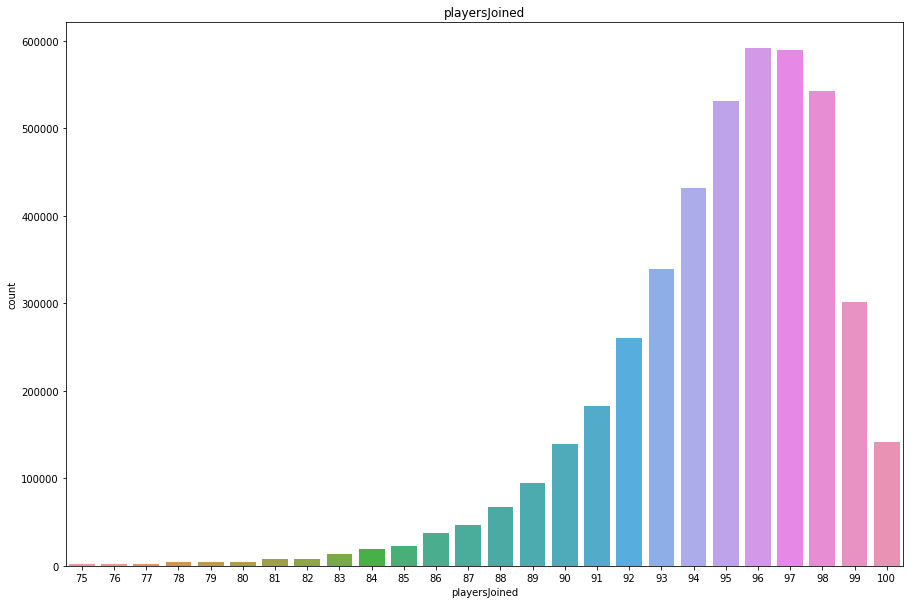

In [13]:
# playersJoined
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(train[train['playersJoined']>=75]['playersJoined'])
plt.title('playersJoined')
plt.show()

There are a few matches with fewer than 75 players that are not displayed here. As you can see most of the matches are nearly packed a have nearly 100 players. It is nevertheless interesting to take these features into our analysis.

### Normalized features

Now that we have a feature 'playersJoined' we can normalize other features based on the amount of players. Features that can be valuable to normalize are:
1. kills
2. damageDealt
3. maxPlace
4. matchDuration

Let's try out some things!

**Normalize features**

基于“playersJoined”功能，我们可以创建（或更改）许多其他功能来规范化其值。 

例如，我将创建“killsNorm”和“damageDealtNorm”功能。 当游戏中有100名玩家时，可能比找到90名玩家更容易找到并杀死某人。 因此，我将以100个玩家的击杀得分1（实际上是这样）的方式将杀伤归一化，并且在90个玩家中它将得分（100-90）/ 100 + 1 = 1.1。 这只是一个假设。 您可以使用不同的比例。

In [14]:
# Create normalized features
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersJoined'])/100 + 1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 + 1)
# Compare standard features and normalized features
to_show = ['Id', 'kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
train[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000,0.00000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.470,99.70230,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000,69.36000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.900,35.86100,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000,103.00000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000,105.00000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000,0.00000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538,8.87952,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.600,53.14800,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.270,38.38810,29,29.87,1930,1987.90


### Heals and Boosts

We create a feature called 'healsandboosts' by adding heals and boosts. (duh!) We are not sure if this has additional predictive value, but we can always delete it later if the feature importance according to our random forest model is too low.

我们通过添加治疗和提升来创建一个名为'healsandboosts'的功能。 （呃！）我们不确定这是否具有额外的预测价值，但如果根据我们的随机森林模型的特征重要性太低，我们可以随后将其删除。

In [15]:
# Create new feature healsandboosts
train['healsandboosts'] = train['heals'] + train['boosts']
train[['heals', 'boosts', 'healsandboosts']].tail()

,heals,boosts,healsandboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


### Killing without moving

We try to identify cheaters by checking if people are getting kills without moving. We first identify the totalDistance travelled by a player and then set a boolean value to True if someone got kills without moving a single inch. We will remove cheaters in our outlier detection section.

我们试图通过检查人们是否在没有移动的情况下获得杀戮来识别作弊者。 我们首先确定玩家行进的总距离，然后如果有人在没有移动一英寸的情况下杀死，则将布尔值设置为True。 我们将删除异常检测部分中的作弊者。

In [16]:
# Create feature totalDistance
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
# Create feature killsWithoutMoving
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

The feature headshot_rate will also help us to catch cheaters.

功能headshot_rate也将帮助我们抓住作弊者,爆头率100%可能为作弊者

In [17]:
# Create headshot_rate feature
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

In [18]:
train[(train['headshot_rate']==1)&(train['kills']>4)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
3646,e19f3c39711470,74206f01bab49b,a2ffc69eeae9a0,0,4,443.5,2,5,2,3,...,0.9556,91,5.45,483.415,50.14,1507.47,6,3065.0000,False,1.0
6483,4545c95e498f96,b1902c9817b107,20600573237106,0,3,596.2,4,5,2,5,...,0.9286,90,5.50,655.820,31.90,1595.00,5,2638.0000,False,1.0
35656,acc2b8b6d7cdbc,e132c5867ff93a,09f691e38ca2c6,0,2,450.0,2,5,1,3,...,0.7660,94,5.30,477.000,50.88,1416.16,3,1410.0000,False,1.0
38956,83df44bc7c31fb,7394f8eef43b65,cd617d849de152,2,3,604.5,2,5,1,2,...,0.9787,94,5.30,640.770,50.88,1496.72,4,3436.0000,False,1.0
43150,b8e8570ab8dd2d,bd2c0a662406cd,e42ade0fb250ab,0,4,587.6,0,5,2,2,...,0.7912,92,5.40,634.608,99.36,1479.60,6,1717.0000,False,1.0
43791,9afbe8ecaec518,19215cc89a51d7,0c70c2be6426f5,0,0,959.4,8,7,0,1,...,0.5833,90,7.70,1055.340,27.50,1508.10,0,2824.0000,False,1.0
45447,eb5516fd4df6fe,45c62861949040,6f46cd41d884d8,0,4,740.5,0,6,2,3,...,0.9896,97,6.18,762.715,99.91,2012.62,6,4403.0000,False,1.0
60540,3ae6bd18a32c7f,4af8b8be0559fb,d024c73e8e9a9b,0,2,559.1,3,5,0,7,...,0.4444,97,5.15,575.873,28.84,1924.04,2,1421.0000,False,1.0
66266,1a23298ecdb19d,d5d54b4be23079,e111ebb6185bc8,0,4,1469.0,9,8,0,2,...,0.7200,94,8.48,1557.140,27.56,1900.58,4,4864.0000,False,1.0
79230,9d23983ef4c4e1,d20e7ba2531be6,a316e8a44f8fcf,0,4,484.2,0,5,0,3,...,0.8602,94,5.30,513.252,99.64,1460.68,4,2646.0000,False,1.0


# Outlier Detection <a id="6"></a>

Some rows in our dataset have weird characteristics. The players could be cheaters, maniacs or just anomalies. Removing these outliers will likely improve results.

我们的数据集中的某些行具有奇怪的特征。 球员可能是骗子，疯子或只是异常。 删除这些异常值可能会改善结果。

Inspiration for this section comes from [this amazing Kaggle Kernel.](https://www.kaggle.com/rejasupotaro/cheaters-and-zombies)

![Alt Text](https://media.giphy.com/media/OPRbXcsGctvZC/giphy.gif)
giphy

**Kills without movement**

This is perhaps the most obvious sign of cheating in the game. It is already fishy if a player hasn't moved during the whole game, but the player could be AFK and got killed. However, if the player managed to get kills without moving it is most likely a cheater.

这可能是游戏中作弊最明显的迹象。 如果一名球员在整场比赛中没有移动，那已经很可疑了，但是球员可能会被AFK杀死。 但是，如果玩家设法在没有移动的情况下获得杀戮，则很可能是骗子。

In [19]:
# Check players who kills without moving
print(train[train['killsWithoutMoving'] == True].shape)
train[train['killsWithoutMoving'] == True].head(10)

(1535, 38)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.00,0,0,3,18,...,0.8571,58,8.52,842.0600,21.30,842.06,3,0.0,True,0.000000
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.60,0,0,6,33,...,0.6000,42,4.74,547.6280,17.38,2834.52,6,0.0,True,0.000000
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.00,0,4,5,3,...,0.8947,21,35.80,3132.5000,35.80,1607.42,5,0.0,True,0.200000
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.80,0,0,0,69,...,0.0000,73,1.27,200.4060,24.13,1014.73,0,0.0,True,0.000000
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.00,0,1,0,37,...,0.3000,42,1.58,158.0000,17.38,2834.52,0,0.0,True,1.000000
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.10,4,1,3,7,...,0.8000,44,9.36,789.5160,9.36,909.48,3,0.0,True,0.166667
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.00,0,4,1,7,...,0.6000,48,18.24,1708.4800,9.12,836.00,1,0.0,True,0.333333
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.90,0,2,11,12,...,0.8571,57,10.01,757.7570,21.45,856.57,11,0.0,True,0.285714
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.90,0,1,6,53,...,0.2857,61,2.78,179.1710,11.12,1017.48,7,0.0,True,0.500000
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.56,0,0,0,46,...,0.8571,53,1.47,125.7732,22.05,1051.05,0,0.0,True,0.000000


In [20]:
'没有任何移动过但是却杀了人的人数为：{}人'.format(train[(train['killsWithoutMoving'] == True)&(train['kills']> 0)].shape[0])

'没有任何移动过但是却杀了人的人数为：1535人'

Got the suckers! 

#### 删除没有移动但是却杀人的玩家信息

In [21]:
# Remove outliers
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

**Anomalies in roadKills**

roadKills中的异常


In [22]:
# Players who got more than 10 roadKills
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,...,0.4286,92,15.12,1345.68,99.36,1572.48,0,1282.302,False,0.000000
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,...,0.4713,88,12.32,1234.24,98.56,2179.52,0,4934.600,False,0.000000
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,...,1.0000,38,32.40,3359.88,61.56,3191.40,19,5876.000,False,0.050000
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,...,0.9398,84,20.88,2164.56,97.44,2233.00,10,7853.000,False,0.277778


In [23]:
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,...,0.4286,92,15.12,1345.68,99.36,1572.48,0,1282.302,False,0.000000
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,...,0.4713,88,12.32,1234.24,98.56,2179.52,0,4934.600,False,0.000000
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,...,1.0000,38,32.40,3359.88,61.56,3191.40,19,5876.000,False,0.050000
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,...,0.9398,84,20.88,2164.56,97.44,2233.00,10,7853.000,False,0.277778


#### 玩家c3e444f7d1289d开了5米，但是却杀死了14人。 听起来疯了不是吗？

In [24]:
train[train['roadKills'] > 10][['rideDistance','kills','roadKills']]

,rideDistance,kills,roadKills
2733926,0.005,14,14
2767999,4118.000,11,11
2890740,2726.000,20,18
3524413,6812.000,18,11


In [25]:
# Drop roadKill 'cheaters'
train.drop(train[train['roadKills'] > 10].index, inplace=True)

Note that player c3e444f7d1289d drove 5 meters but killed 14 people with it. Sounds insane doesn't it?

请注意，玩家c3e444f7d1289d开了5米，但是却杀死了14人。 听起来疯了不是吗？

![Alt Text](https://media.giphy.com/media/3o7aD85usFbbbrCR3i/giphy.gif)
giphy3


**Anomalies in aim (More than 45 kills)**

Let's plot the total kills for every player first. It doesn't look like there are too many outliers.

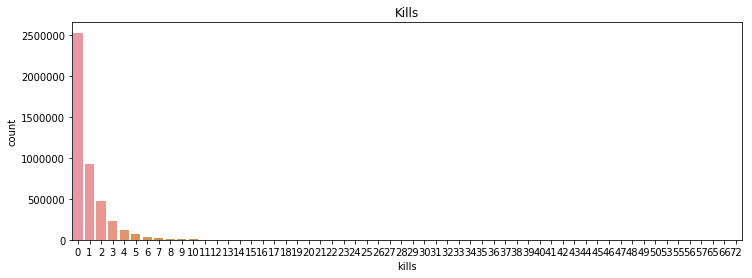

In [26]:
# Plot the distribution of kills
plt.figure(figsize=(12,4))
sns.countplot(data=train, x=train['kills']).set_title('Kills')
plt.show()

Let's take a closer look.

In [27]:
# Players who got more than 30 kills
display(train[train['kills'] > 30].shape)
train[train['kills'] > 30].sort_values(by='totalDistance',ascending=False)

(95, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
3840888,7614924933b454,7de402ea23a8ef,59e23ee8543fd2,7,19,3796.0,32,26,4,1,...,1.0000,94,34.98,4023.76,28.62,2078.66,23,9083.480,False,0.787879
1248675,3e3d05d6a84c3a,fc1c3ff93afeb9,cfa2775c9ef944,2,0,3145.0,0,9,19,4,...,0.9167,41,52.47,5000.55,58.83,2857.23,19,4957.000,False,0.272727
1961750,afd6a48ff78f14,f039c600e76dfe,44b7250c12c521,8,0,3987.0,0,6,2,1,...,1.0000,16,69.92,7336.08,29.44,3310.16,2,4561.000,False,0.157895
1491277,1f6ceaa5140fb6,dc2fef63e14d5c,f900de1ec39fa5,15,0,5468.0,0,13,5,2,...,0.9000,11,105.84,10334.52,20.79,3398.22,5,4551.000,False,0.232143
2381682,58abc1acf966c3,8a3bcebc8e3621,b181e5bc4f0c1d,6,1,3122.0,0,6,4,2,...,0.2857,32,52.08,5244.96,13.44,1737.12,5,3986.000,False,0.193548
4021018,1f1c3dda0296df,7c95f475fd2cdb,a9e84c456cc859,6,0,3406.0,0,8,10,2,...,0.9167,13,57.97,6369.22,24.31,3356.65,10,3817.000,False,0.258065
3702869,e0ea16ac6718e4,5bc75ce9e16956,e024bf51bf1799,13,0,4352.0,0,9,4,3,...,0.8889,19,77.83,7877.12,34.39,3254.38,4,3384.000,False,0.209302
2373649,0cf370d58b7745,3771a97ff96237,b06aa721ab324a,7,0,3458.0,0,8,6,3,...,0.8333,13,63.58,6466.46,24.31,3364.13,6,3301.000,False,0.235294
3730946,fb127150830c2d,62bc19a85c2ed8,17dea22cefe62a,5,0,4313.0,0,5,5,3,...,0.9286,28,79.12,7418.36,25.80,3092.56,5,3001.000,False,0.108696
917559,3680e10f7f1836,fa4e278cfd3346,91af04985f6b36,3,0,2695.0,0,4,22,2,...,1.0000,32,55.44,4527.60,6.72,2501.52,22,2914.000,False,0.121212


In [28]:
# Remove outliers
train.drop(train[train['kills'] > 30].index, inplace=True)

What do you think? Should we remove all these outliers from our dataset?

你怎么看？ 我们应该从数据集中删除所有这些异常值吗？

**Anomalies in aim part 2 (100% headshot rate)**

目标第2部分的异常（100％爆头率）


Again, we first take a look at the whole dataset and create a new feature 'headshot_rate'.
We see that the most players score in the 0 to 10% region. However, there are a few anomalies that have a headshot_rate of 100% percent with more than 9 kills!

再次，我们首先看一下整个数据集并创建一个新功能'headshot_rate'。 我们看到大多数球员在0到10％的区域得分。 但是，有一些异常现象的爆发率为100％，超过9次杀戮！

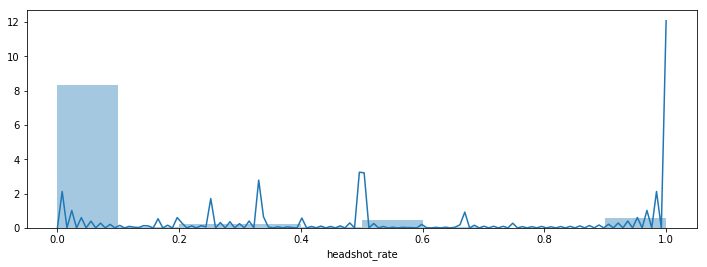

In [29]:
# Plot the distribution of headshot_rate
plt.figure(figsize=(12,4))
sns.distplot(train['headshot_rate'], bins=10)
plt.show()

In [30]:
# Players who made a minimum of 10 kills and have a headshot_rate of 100%
display(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape)
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].head(10)

(24, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,...,0.8462,93,10.70,1296.84,28.89,1522.61,3,2939.0,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,...,1.0000,96,11.44,1684.80,28.08,1796.08,8,8142.0,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,...,1.0000,98,13.26,1392.30,27.54,1280.10,4,2105.0,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,...,0.9630,95,10.50,1611.75,29.40,1929.90,8,7948.0,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,...,1.0000,96,10.40,1409.20,28.08,1473.68,8,3476.0,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,...,1.0000,95,11.55,1278.90,29.40,1912.05,8,8178.0,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,...,1.0000,97,10.30,1096.95,27.81,1283.38,5,2858.9,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,...,1.0000,93,12.84,1411.33,29.96,1851.10,6,5963.0,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,...,1.0000,88,12.32,1288.00,51.52,1397.76,5,3108.0,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,...,1.0000,96,13.52,1537.12,50.96,1434.16,12,2479.8,False,1.0


It is unclear if these players are cheating so we are probably not deleting these players from the dataset.
If they are legitimate players, they are probably really crushing the game!

目前还不清楚这些玩家是否在作弊，所以我们可能不会从数据集中删除这些玩家。 如果他们是合法的球员，他们可能真的很难打败比赛！

![Alt Text](https://media.giphy.com/media/l3mZrOajz5VCZf7Hy/giphy.gif)
giphy4

**Anomalies in aim part 3 (Longest kill)**

Most kills are made from a distance of 100 meters or closer. There are however some outliers who make a kill from more than 1km away. This is probably done by cheaters.

大多数杀戮都是在100米或更近的距离内完成的。 然而，有一些异常值从1公里以外的地方杀死。 这可能是骗子所做的。

但是也有可能是因为是击倒之后离开，然后敌人死亡造成

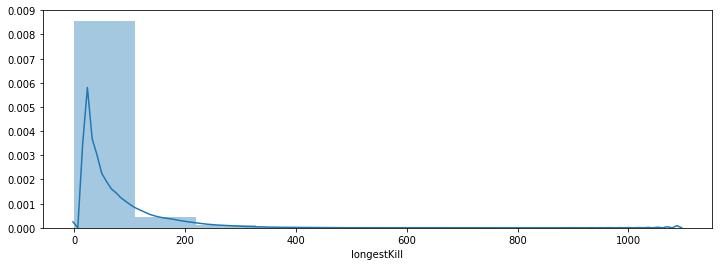

In [31]:
# Plot the distribution of longestKill
plt.figure(figsize=(12,4))
sns.distplot(train['longestKill'], bins=10)
plt.show()

Let's take a look at the players who make these shots.

In [32]:
# Check out players who made kills with a distance of more than 1 km
display(train[train['longestKill'] >= 1000].shape)
train[train['longestKill'] >= 1000].head(10)

(20, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.9,5,1,1,5,...,0.9231,88,4.48,877.968,30.24,2087.68,4,3775.20,False,0.250000
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.0,8,5,7,18,...,0.5385,29,18.81,2195.640,23.94,2236.68,7,48.87,False,0.454545
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.0,0,0,0,9,...,1.0000,51,14.90,1531.720,19.37,1040.02,0,2981.00,False,0.000000
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.0,17,5,0,3,...,0.6000,41,25.44,2241.900,9.54,1734.69,0,29.21,False,0.312500
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.8,0,0,0,51,...,0.0000,61,1.39,273.552,11.12,654.69,0,3159.00,False,0.000000
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.0,11,5,0,5,...,0.9091,86,11.40,1153.680,13.68,1163.94,0,569.50,False,0.500000
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.3,0,0,2,45,...,0.2857,58,4.26,467.606,11.36,825.02,3,832.50,False,0.000000
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.0,0,7,0,1,...,0.9412,52,22.20,2427.200,76.96,1827.80,6,2848.00,False,0.466667
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.0,0,4,11,11,...,0.5000,28,39.56,3617.160,25.80,3092.56,13,235.30,False,0.173913
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.0,0,6,5,15,...,0.6000,42,17.38,2057.160,17.38,2834.52,8,133.20,False,0.545455


In [33]:
# Remove outliers
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

There is something fishy going on with these players. We are probably better off removing them from our dataset.

这些球员有些可疑。 我们最好从数据集中删除它们。

![Alt Text](https://media.giphy.com/media/RHJkLqcdvMQF4GI3P7/giphy.gif)


**Anomalies in travelling (rideDistance, walkDistance and swimDistance)**

Let's check out anomalies in Distance travelled.

In [34]:
# Summary statistics for the Distance features
train[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4.445311e+06,4.445311e+06,4.445311e+06,4.445311e+06
mean,1.154628e+03,6.063272e+02,4.510977e+00,1.765466e+03
std,1.183514e+03,1.498567e+03,3.050773e+01,2.183257e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00,1.584000e+02
50%,6.864000e+02,0.000000e+00,0.000000e+00,7.893000e+02
75%,1.977000e+03,2.606500e-01,0.000000e+00,2.729000e+03
max,2.578000e+04,4.071000e+04,3.823000e+03,4.127010e+04


**walkDistance**

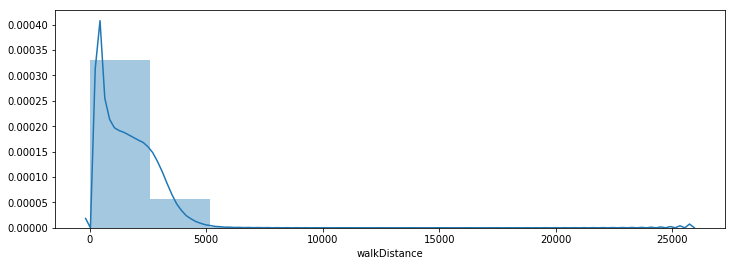

In [35]:
# Plot the distribution of walkDistance
plt.figure(figsize=(12,4))
sns.distplot(train['walkDistance'], bins=10)
plt.show()

In [36]:
# walkDistance anomalies
display(train[train['walkDistance'] >= 10000].shape)
train[train['walkDistance'] >= 10000].head(10)

(219, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.00,0,0,0,44,...,0.8163,99,0.00,0.0000,99.99,1925.06,1,13540.3032,False,0.0
34344,5a591ecc957393,6717370b51c247,a15d93e7165b05,0,3,23.22,0,0,1,34,...,0.9474,65,0.00,31.3470,27.00,2668.95,4,10070.9073,False,0.0
49312,582685f487f0b4,338112cd12f1e7,d0afbf5c3a6dc9,0,4,117.20,1,0,1,24,...,0.9130,94,1.06,124.2320,49.82,2323.52,5,12446.7588,False,0.0
68590,8c0d9dd0b4463c,c963553dc937e9,926681ea721a47,0,1,32.34,0,0,1,46,...,0.8333,96,0.00,33.6336,50.96,1909.44,2,12483.6200,False,0.0
94400,d441bebd01db61,7e179b3366adb8,923b57b8b834cc,1,1,73.08,0,0,3,27,...,0.8194,73,0.00,92.8116,92.71,2293.62,4,11490.6300,False,0.0
125103,db5a0cdc969dcb,50cc466757950e,c306a9745c4c1d,0,4,37.73,0,0,7,47,...,0.7340,95,0.00,39.6165,99.75,2054.85,11,12828.7978,False,0.0
136421,955e60b09a96b1,30df08fe22a901,8669d01725f135,0,1,0.00,0,0,1,46,...,0.6957,94,0.00,0.0000,49.82,2091.38,2,12223.8100,False,0.0
136476,0d75d05b5c988c,3da040ce77cd0b,65bc5211a569dd,0,3,0.00,0,0,0,41,...,0.9333,91,0.00,0.0000,99.19,2028.49,3,14918.2000,False,0.0
154080,7e8a71d23381cd,e2c9f4f92840b2,a721de1aa05408,0,3,0.00,0,0,13,46,...,0.8602,94,0.00,0.0000,99.64,2038.38,16,12636.7000,False,0.0
154128,32fdde4c716787,390ae9a51c11b8,82610ed1b4d033,0,4,52.16,0,0,7,25,...,0.8936,95,1.05,54.7680,50.40,1927.80,11,10889.8614,False,0.0


In [37]:
# Remove outliers
train.drop(train[train['walkDistance'] >= 10000].index, inplace=True)

**rideDistance**

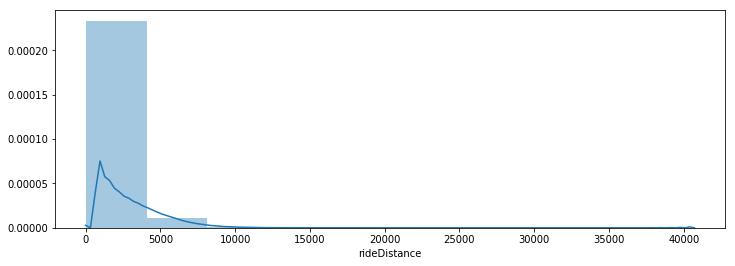

In [38]:
# Plot the distribution of rideDistance
plt.figure(figsize=(12,4))
sns.distplot(train['rideDistance'], bins=10)
plt.show()

In [39]:
# rideDistance anomalies
display(train[train['rideDistance'] >= 20000].shape)
train[train['rideDistance'] >= 20000].head(10)

(150, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
28588,6260f7c49dc16f,b24589f02eedd7,6ebea3b4f55b4a,0,0,99.20,0,0,1,30,...,0.6421,96,1.04,103.1680,99.84,1969.76,1,26306.60,False,0.000000
63015,adb7dae4d0c10a,8ede98a241f30a,8b36eac66378e4,0,0,0.00,0,0,0,55,...,0.5376,94,0.00,0.0000,99.64,2004.46,0,22065.40,False,0.000000
70507,ca6fa339064d67,f7bb2e30c3461f,3bfd8d66edbeff,0,0,100.00,0,0,0,26,...,0.8878,99,1.01,101.0000,99.99,1947.28,0,28917.50,False,0.000000
72763,198e5894e68ff4,ccf47c82abb11f,d92bf8e696b61d,0,0,0.00,0,0,0,46,...,0.7917,97,0.00,0.0000,99.91,1861.21,0,21197.20,False,0.000000
95276,c3fabfce7589ae,15529e25aa4a74,d055504340e5f4,0,7,778.20,0,1,2,2,...,0.9785,94,7.42,824.8920,99.64,1986.44,9,26733.20,False,0.142857
140097,9944fbbea2b91e,18b4d5f4bb1906,d9d4a3e50cae75,1,0,12.55,0,0,0,53,...,0.5000,89,0.00,13.9305,98.79,2107.89,0,21293.23,False,0.000000
297186,88904c200175b6,012a61a01e146e,7a270c25e9b70c,0,1,0.00,0,0,1,47,...,0.7447,96,0.00,0.0000,49.92,1995.76,2,29267.30,False,0.000000
371098,f7071357f6b762,f3ee20821f4627,ac47c86bf385bf,0,0,72.92,1,0,0,45,...,0.6875,96,0.00,75.8368,50.96,1953.12,0,21942.10,False,0.000000
403647,c65da7b3fceef5,814d1b3736e276,ff9f570b555d48,0,2,0.00,0,0,3,54,...,0.6739,94,0.00,0.0000,49.82,1930.26,5,21198.20,False,0.000000
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.00,0,0,2,43,...,0.8171,83,0.00,0.0000,97.11,2348.19,4,32362.10,False,0.000000


In [40]:
# Remove outliers
train.drop(train[train['rideDistance'] >= 20000].index, inplace=True)

Cheaters or do they just like to ride like these guys?

![Alt Text](https://media.giphy.com/media/qlCFjkSruesco/giphy.gif)

**swimDistance**

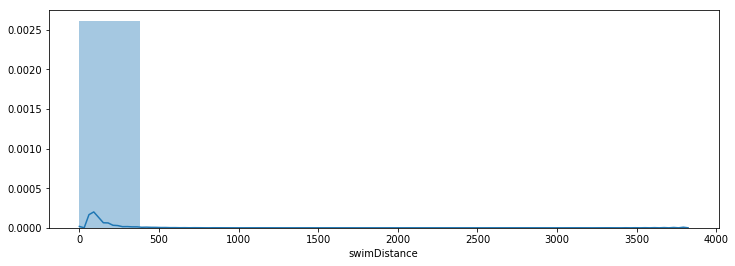

In [41]:
# Plot the distribution of swimDistance
plt.figure(figsize=(12,4))
sns.distplot(train['swimDistance'], bins=10)
plt.show()

In [42]:
# Players who swam more than 2 km
train[train['swimDistance'] >= 2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.12,1,0,1,47,...,0.9592,98,0.00,79.6824,51.00,1426.98,6,3297.000,False,0.000000
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.32,0,0,16,39,...,0.9600,94,0.00,56.5192,27.56,2319.28,20,10113.000,False,0.000000
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.00,4,3,1,6,...,1.0000,88,3.36,563.3600,29.12,2124.64,2,10740.000,False,1.000000
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.30,3,1,6,4,...,1.0000,98,5.10,359.3460,49.98,1423.92,13,3083.100,False,0.200000
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.20,3,1,1,46,...,1.0000,86,2.28,671.6880,13.68,1163.94,2,4818.300,False,0.500000
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.00,0,0,0,47,...,0.5833,87,0.00,0.0000,28.25,1567.31,0,5314.000,False,0.000000
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.59,0,0,5,48,...,0.8511,96,0.00,51.5736,49.92,1434.16,8,9899.000,False,0.000000
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.40,2,0,0,7,...,1.0000,91,3.27,517.0960,29.43,1318.90,1,2394.546,False,0.000000
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,843.80,5,5,2,2,...,0.9600,94,7.42,894.4280,27.56,2319.28,6,9926.000,False,0.714286
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.00,0,0,0,77,...,0.2143,96,0.00,0.0000,30.16,1426.88,0,4088.000,False,0.000000


In [43]:
# Remove outliers
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

Do you think these guys are legit?

![Alt Text](https://thumbs.gfycat.com/EvenSpiffyFerret-size_restricted.gif)

**Anomalies in supplies (weaponsAcquired)**

Most people acquire between 0 and 10 weapons in a game, but you also see some people acquire more than 80 weapons! Let's check these guys out.

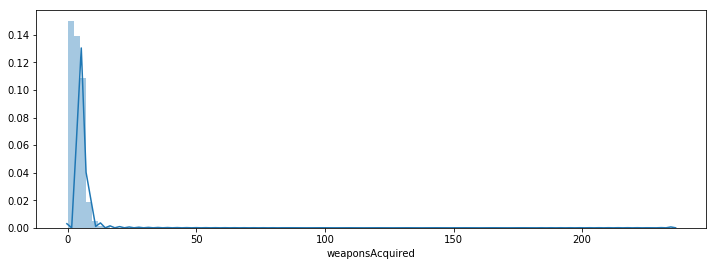

In [44]:
# Plot the distribution of weaponsAcquired
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=100)
plt.show()

In [45]:
# Players who acquired more than 80 weapons
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()

(19, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.11,0,0,0,44,...,0.7111,91,0.00,73.1499,50.14,2072.09,0,3187.00,False,0.000000
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.30,1,0,2,48,...,0.7500,98,0.00,178.8060,29.58,1399.44,3,1687.00,False,0.000000
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.00,0,0,0,24,...,0.8929,97,1.03,103.0000,29.87,1895.20,0,5299.21,False,0.000000
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.00,0,0,0,54,...,0.5600,80,0.00,0.0000,31.20,1596.00,0,653.10,False,0.000000
1592744,634a224c53444e,75fa7591d1538c,f900de1ec39fa5,9,0,1726.00,0,3,0,9,...,0.2000,11,43.47,3262.1400,20.79,3398.22,0,2888.80,False,0.130435


In [46]:
# Remove outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

We should probably remove these outliers from our model. Do you agree?

Note that player 3f2bcf53b108c4 acquired 236 weapons in one game!

![Alt Text](https://media.giphy.com/media/69lWR6c8Afx9qeg2Tu/giphy.gif)

**Anomalies in supplies part 2 (heals)**

Most players us 5 healing items or less. We can again recognize some weird anomalies

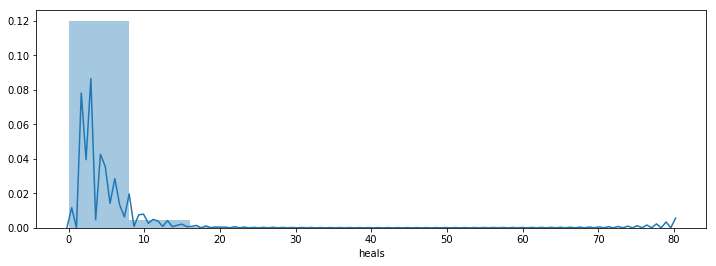

In [47]:
# Distribution of heals
plt.figure(figsize=(12,4))
sns.distplot(train['heals'], bins=10)
plt.show()

In [48]:
# 40 or more healing items used
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)

(135, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,...,0.9368,96,0.00,0.00,99.84,1868.88,49,6854.000,False,0.000000
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,...,0.9615,93,1.07,194.74,28.89,1639.24,47,3083.400,False,1.000000
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,...,0.8333,97,0.00,0.00,99.91,1415.22,54,1343.443,False,0.000000
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,...,0.8646,97,0.00,0.00,99.91,1822.07,52,7444.000,False,0.000000
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,...,0.8370,93,0.00,0.00,99.51,2009.46,53,5816.000,False,0.000000
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,...,0.9259,97,0.00,0.00,28.84,1333.85,44,2439.000,False,0.000000
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,...,0.8276,99,0.00,124.23,30.30,1984.65,43,4848.000,False,0.000000
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,...,0.9355,95,1.05,183.75,33.60,1425.90,53,3415.600,False,1.000000
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,...,0.8889,41,42.93,3733.32,58.83,2857.23,41,268.800,False,0.296296
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,...,0.9630,94,4.24,295.21,29.68,1915.42,51,4927.000,False,0.250000


In [49]:
# Remove outliers
train.drop(train[train['heals'] >= 40].index, inplace=True)

**Outlier conclusions**

We removed about 2000 players from our dataset. Do you think this is too much? Please let us know in the comments.

In [50]:
# Remaining players in the training set
train.shape

(4444776, 38)

# Categorical Variables <a id="7"></a>

We will one hot encode the 'matchType' feature to use it in our Random Forest model.

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4444776 entries, 0 to 4446965
Data columns (total 38 columns):
Id                    object
groupId               object
matchId               object
assists               int64
boosts                int64
damageDealt           float64
DBNOs                 int64
headshotKills         int64
heals                 int64
killPlace             int64
killPoints            int64
kills                 int64
killStreaks           int64
longestKill           float64
matchDuration         int64
matchType             object
maxPlace              int64
numGroups             int64
rankPoints            int64
revives               int64
rideDistance          float64
roadKills             int64
swimDistance          float64
teamKills             int64
vehicleDestroys       int64
walkDistance          float64
weaponsAcquired       int64
winPoints             int64
winPlacePerc          float64
playersJoined         int64
killsNorm             float64
d

In [52]:
print('There are {} different Match types in the dataset.'.format(train['matchType'].nunique()))

There are 16 different Match types in the dataset.


In [53]:
pd.get_dummies(train, columns=['matchType'])

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,...,0,0,0,0,0,0,0,0,0,1
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,...,0,0,0,0,0,0,0,0,0,1
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,0,0,0,0,0,0,0,0,0,0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,...,0,0,0,0,0,0,0,0,0,1
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,0,0,0,0,0,0,0,1,0,0
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000,1,1,0,44,...,0,0,0,0,0,0,0,0,0,1
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000,0,0,0,96,...,0,0,0,0,0,0,0,0,0,1
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,...,0,0,0,0,0,0,0,1,0,0
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.600,0,0,0,64,...,0,0,0,0,0,0,0,0,1,0
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.270,0,0,0,74,...,0,0,0,0,0,0,0,0,1,0


In [54]:
# One hot encode matchType
train = pd.get_dummies(train, columns=['matchType'])

# Take a look at the encoding
matchType_encoding = train.filter(regex='matchType')
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


There are a lot of groupId's and matchId's so one-hot encoding them is computational suicide.
We will turn them into category codes. That way we can still benefit from correlations between groups and matches in our Random Forest algorithm.

有很多groupId和matchId，所以单热编码就是计算自杀。 我们将把它们变成类别代码。 这样我们仍然可以从随机森林算法中的组和匹配之间的相关性中受益。

因为使用的是随机森林所以特征之间的大小对模型没有什么影响所以可以采用分类标签

In [55]:
# Turn groupId and match Id into categorical types
# 转换为分类类型
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

# Get category coding for groupId and matchID
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

# Get rid of old columns
train.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613591,30085
1,827582,32751
2,843273,3143
3,1340072,45260
4,1757338,20531


In [56]:
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
train.drop(columns = ['Id'], inplace=True)

**voilà!**

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4444776 entries, 0 to 4446965
Data columns (total 52 columns):
assists                       int64
boosts                        int64
damageDealt                   float64
DBNOs                         int64
headshotKills                 int64
heals                         int64
killPlace                     int64
killPoints                    int64
kills                         int64
killStreaks                   int64
longestKill                   float64
matchDuration                 int64
maxPlace                      int64
numGroups                     int64
rankPoints                    int64
revives                       int64
rideDistance                  float64
roadKills                     int64
swimDistance                  float64
teamKills                     int64
vehicleDestroys               int64
walkDistance                  float64
weaponsAcquired               int64
winPoints                     int64
winPlacePerc 

# Preparation for Machine Learning <a id="8"></a>

## Sampling

We will take a sample of 500000 rows from our training set for easy debugging and exploration.

In [58]:
# Take sample for debugging and exploration
sample = 50000
df_sample = train.sample(sample)

## Split target variable, validation data, etc.

In [59]:
# Split sample into training data and target variable
df = df_sample.drop(columns = ['winPlacePerc']) # all columns except target
y = df_sample['winPlacePerc'] # Only target variable

In [60]:
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# Check dimensions of samples
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 51) Sample target shape:  (440000,) Sample validation shape:  (60000, 51)


## Set metrics (MAE)

[Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) is the metric that is used for this competition. The scikit-learn library already programmed this metric for us so we don't have to implement it from scratch.

In [61]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE (Mean Absolute Error) score
# This is the metric used by Kaggle in this competition
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Set metrics (RMSE)

In [63]:
from sklearn.model_selection import KFold,cross_val_score

In [64]:
from sklearn.metrics import mean_squared_error

kfolds=5

def rmse_cv(model):
    kf = KFold(kfolds,shuffle=False,random_state=42)
    rmse = np.sqrt(-cross_val_score(model,df,y,scoring='neg_mean_squared_error',cv=kf)).mean()
    return rmse

## First basic Random Forest Model

In [62]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.039258911896183524, 'mae val: ', 0.06257542014686016]


In [65]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
score = rmse_cv(m1)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

array([0.08834588, 0.0889172 , 0.08859116, 0.08847362, 0.08721594])

# Feature Importance <a id="9"></a>

The [fastai](https://www.fast.ai/) library gives us an easy way to analyze feature importances from a random forest algorithm with just one line of code!

In [75]:
# What are the most predictive features according to our basic random forest model
fi = rf_feat_importance(m1, df); fi[:10]

In [116]:
fi_threshold=20
feature_importance = m1.feature_importances_
feature_importance = 100*(feature_importance/feature_importance.max())
important_inx = np.where(feature_importance > fi_threshold)
feature_name = df.columns[important_inx]

new_feature = pd.DataFrame(y_importances[important_inx],index=feature_name,columns=['feature_importamce'])
new_feature = new_feature.sort_values(by='feature_importamce',ascending=True)

In [117]:
y_pos = np.arange(len(new_feature))

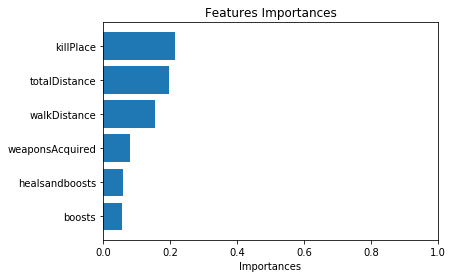

In [118]:
plt.barh(y_pos, new_feature['feature_importamce'], align='center')
plt.yticks(y_pos, new_feature.index)
plt.xlabel('Importances')
plt.xlim(0,1)
plt.title('Features Importances')
plt.show()

In [ ]:
# Plot a feature importance graph for the 20 most important features
plot1 = fi[:20].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

In [ ]:
# Use this code if you want to save the figure
#fig = plot1.get_figure()
#fig.savefig("Feature_importances(AllFeatures).png")

In [ ]:
# Keep only significant features
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

In [ ]:
# Make a DataFrame with only significant features
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

## Second Random Forest Model

This time we use only the top features to train a random forest model. This often improves results a little bit.

In [ ]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

**Feature importance for top features**

In [ ]:
# Get feature importances of our top features
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

# Use this code if you want to save the figure
#fig = plot2.get_figure()
#fig.savefig("Feature_importances(TopFeatures).png")

## Correlations

**Dendrogram (to view correlation of features)**

In [122]:
# Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.plot()

In [ ]:
# Use this code if you want to save the figure
#plt.savefig('Dendrogram.png')

**Correlation Heatmap**

In [ ]:
# Correlation heatmap
corr = df_keep.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Create heatmap
heatmap = sns.heatmap(corr)

In [ ]:
# Use this code if you want to save the figure
#fig = heatmap.get_figure()
#fig.savefig("Heatmap(TopFeatures).png")

**Predictive quality of kills**

In [ ]:
# Plot the predictive quality of kills 
x_all = get_sample(train, 100000)
ggplot(x_all, aes('kills','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

**Predictive quality of walkDistance**

In [ ]:
# Plot the predictive quality of walkDistance
x_all = get_sample(train, 100000)
ggplot(x_all, aes('walkDistance','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

# Final Random Forest Model <a id="10"></a>

In [ ]:
# Prepare data
val_perc_full = 0.12 # % to use for validation set
n_valid_full = int(val_perc_full * len(train)) 
n_trn_full = len(train)-n_valid_full
df_full = train.drop(columns = ['winPlacePerc']) # all columns except target
y = train['winPlacePerc'] # target variable
df_full = df_full[to_keep] # Keep only relevant features
X_train, X_valid = split_vals(df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)

# Check dimensions of data
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

In [ ]:
# Train final model
# You should get better results by increasing n_estimators
# and by playing around with the parameters
m3 = RandomForestRegressor(n_estimators=70, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)

# Kaggle Submission <a id="11"></a>

In [ ]:
# Add engineered features to the test set
test['headshot_rate'] = test['headshotKills'] / test['kills']
test['headshot_rate'] = test['headshot_rate'].fillna(0)
test['totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['killsNorm'] = test['kills']*((100-test['playersJoined'])/100 + 1)
test['damageDealtNorm'] = test['damageDealt']*((100-test['playersJoined'])/100 + 1)
test['maxPlaceNorm'] = test['maxPlace']*((100-train['playersJoined'])/100 + 1)
test['matchDurationNorm'] = test['matchDuration']*((100-test['playersJoined'])/100 + 1)
test['healsandboosts'] = test['heals'] + test['boosts']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['totalDistance'] == 0))

# Turn groupId and match Id into categorical types
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

# Remove irrelevant features from the test set
test_pred = test[to_keep].copy()

# Fill NaN with 0 (temporary)
test_pred.fillna(0, inplace=True)
test_pred.head()

In [ ]:
# Make submission ready for Kaggle
# We use our final Random Forest model (m3) to get the predictions
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})

# Create submission file
pred_df.to_csv("submission.csv", index=False)

**Check of submission file**

It is always nice to take a look at few of your predictions to make sure that the structure is right for a Kaggle submission.

In [ ]:
# Last check of submission
print('Head of submission: ')
display(pred_df.head())
print('Tail of submission: ')
display(pred_df.tail())

#### 数据中的各种击杀人数分析

In [47]:
'平均每个人击杀 {:.4f} 个玩家,99% 的人击杀了 {} 个人或者更少 ,一局中最高击杀的人数的数量是 {}'.format(train['kills'].mean(),train['kills'].quantile(0.99),train['kills'].max())

'平均每个人击杀 0.9248 个玩家,99% 的人击杀了 7.0 个人或者更少 ,一局中最高击杀的人数的数量是 72'

#### 爆头率展示

In [63]:
train[(train['headshot_rate']==1) & (train['kills'] >9)][['Id','totalDistance','kills','headshot_rate']].rename(columns={'totalDistance':'移动总距离(m)','kills':'击杀总人数','headshot_rate':'爆头率'})

,Id,移动总距离(m),击杀总人数,爆头率
281570,ab9d7168570927,2939.00,10,1.0
346124,044d18fc42fc75,8142.00,11,1.0
871244,e668a25f5488e3,2105.00,13,1.0
908815,566d8218b705aa,7948.00,10,1.0
963463,1bd6fd288df4f0,3476.00,10,1.0
1079403,1c245ed99b5f96,8178.00,11,1.0
1167959,c4f80d4be5c561,2858.90,10,1.0
1348164,474a641f0a4bcb,5963.00,12,1.0
1380385,202ce6a55119c5,3108.00,11,1.0
1483199,9d483f7cbb34d4,2479.80,13,1.0


In [58]:
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)
'爆头率为100% 击杀人数超过 9 人的有 {} 个人'.format(train[(train['headshot_rate']==1) & (train['kills'] >9)].shape[0])

'爆头率为100% 击杀人数超过 9 人的有 24 个人'

#### 没有任何移动过 但是却杀了人的人数

In [46]:
'没有任何移动过但是却杀了人的人数为：{} 人'.format(train[(train['killsWithoutMoving'] == True)&(train['kills']> 0)].shape[0])

'没有任何移动过但是却杀了人的人数为：1535 人'

#### 通过驾驶车辆 杀伤人数 超过十个人的情况

In [41]:
train[train['roadKills'] > 10][['Id','rideDistance','kills','roadKills']].rename(columns={'rideDistance':'驾驶距离(m)','kills':'击杀总人数','roadKills':'通过驾驶车辆击杀人数'})

,Id,驾驶距离(m),击杀总人数,通过驾驶车辆击杀人数
2733926,c3e444f7d1289f,0.005,14,14
2767999,34193085975338,4118.000,11,11
2890740,a3438934e3e535,2726.000,20,18
3524413,9d9d044f81de72,6812.000,18,11


请注意，玩家c3e444f7d1289d开了5米，但是却杀死了14人。  比传说中的十步杀一人还厉害。听起来疯了不是吗？

#### 一局下来使用治疗药品的最大次数

In [45]:
'一局下来使用治疗药品的最大次数为 {} 次'.format(train['heals'].max())

'一局下来使用治疗药品的最大次数为 80 次'

#### 一局下来复活队友的最大次数

In [67]:
'一局下来复活队友的最大次数为 {} 次'.format(train['revives'].max())

'一局下来复活队友的最大次数为 39 次'

#### 一局下来拾取武器的最大次数

In [68]:
'一局下来拾取武器的最大次数为 {} 次'.format(train['weaponsAcquired'].max())

'一局下来拾取武器的最大次数为 236 次'